This tutorial assumes you have gone through the Trace and Wavelength Calibration tutorials

Repeat the trace-and-extract process derived in trace:

In [1]:
from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

In [2]:
image_array_2 = np.array(Image.open('deneb_3s_13.63g_1.bmp'))

In [3]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

In [4]:
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
xvals = np.arange(image_array_2.shape[1])
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:] - np.median(image_array_2))
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [5]:
npixels_to_cut = 15
trace_center = fitted_polymodel2(xvals)
cutouts = np.array([image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
cutouts.shape
mean_trace_profile = cutouts.mean(axis=0)

In [6]:
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

Retrieve the wavelength solution\\

In [7]:
from astropy.modeling.models import Linear1D
wlmodel = Linear1D(slope=-0.10213643, intercept=562.3862495)

In [8]:
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f1c0db24650>

In [9]:
wavelengths = wlmodel(xvals) * u.nm

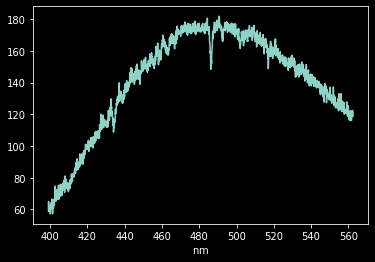

In [10]:
pl.plot(wavelengths, spectrum2)

In [11]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

[470, 510, 140, 190]

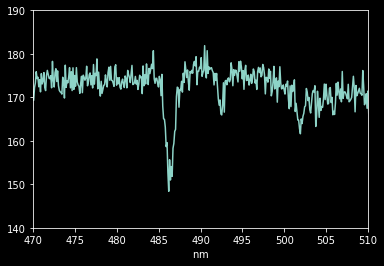

In [12]:
pl.plot(wavelengths, spectrum2)
pl.axis([470,510,140,190])

In [13]:
absorption_model_guess = Linear1D(slope=0, intercept=175) + Gaussian1D(amplitude=-25, mean=486, stddev=3)

[470, 510, 140, 190]

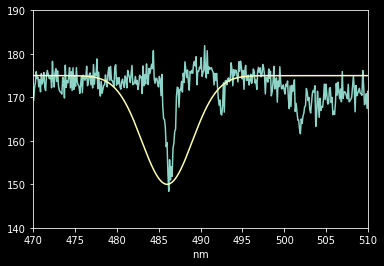

In [14]:
pl.plot(wavelengths, spectrum2)
pl.plot(wavelengths, absorption_model_guess(wavelengths.value))
pl.axis([470,510,140,190])

In [15]:
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 470*u.nm) & (wavelengths < 500*u.nm) 
fitted_absorption_model = lmfitter(model=absorption_model_guess, x=wavelengths.value[selection], y=spectrum2[selection])

[470, 510, 140, 190]

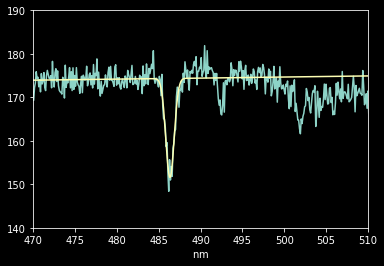

In [16]:
pl.plot(wavelengths, spectrum2)
pl.plot(wavelengths, fitted_absorption_model(wavelengths.value))
pl.axis([470,510,140,190])

In [17]:
continuum_fit, absorption_fit = fitted_absorption_model

[470, 510, 140, 190]

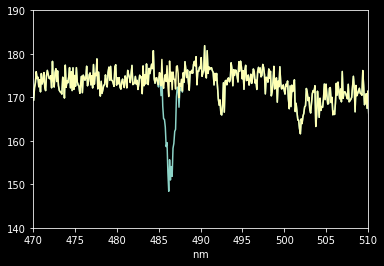

In [18]:
pl.plot(wavelengths, spectrum2)
pl.plot(wavelengths, spectrum2 - absorption_fit(wavelengths.value))
pl.axis([470,510,140,190])

In [19]:
EQW =  -absorption_fit(wavelengths.value[selection]).sum() / continuum_fit.intercept *u.nm
EQW

<Quantity 1.71268556 nm>

In [20]:
absorption_fit

<Gaussian1D(amplitude=-22.81529847, mean=486.34296327, stddev=0.4969129)>

In [21]:
air_wavelength_hbeta = 486.135*u.nm # wikipedia https://en.wikipedia.org/wiki/Balmer_series

In [22]:
from astropy import constants

In [23]:
doppler_velocity = (absorption_fit.mean*u.nm - air_wavelength_hbeta) / (air_wavelength_hbeta) * constants.c
doppler_velocity.to(u.km/u.s)

<Quantity 128.24795739 km / s>

In [24]:
doppler_velocity = (absorption_fit.mean*u.nm).to(u.km/u.s, u.doppler_optical(air_wavelength_hbeta))
doppler_velocity

<Quantity 128.24795739 km / s>

In [25]:
linewidth_kms = (absorption_fit.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms

<Quantity 306.43903635 km / s>